# Árboles de Decisión Random Forest (Regresión)

## 1. Librerias y configuraciones previas


In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================

#creación de modelos
from sklearn.ensemble import RandomForestRegressor


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler

#import statsmodels.api as sm
import math

#evaluacion de variables
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## 2. Funciones

In [2]:
# Función para graficar un plot con multiples gráficas del mismo tipo:
#
# df       : dataframe 
# cols     : lista de columnas a graficar
# num_cols : número de columnas 
# num_rows : número de filas
# tipo     : 'c' = countplot,   'b' = boxplot, 's' = scatterplot 
# targetVar: nombre de la variable comparativa de salida. Debe ser numérica y debe estar cotenida en el dataframe. 
#            Para countplot no es necesario (None)
# figsize  : tamaño del plot. Valor por defecto (16,8)
#
# *Nota: el número de filas * el número de columnas debe ser mayor al total de elementos de cols
#
# Ejemplos:     
#    plot_multiples_graficas (d, catCols, 5, 3, 'c', None, (16,12))
#    plot_multiples_graficas (d, numCols, 5, 3, 's', 'price', (16,12))
#    plot_multiples_graficas (d, ['make'], 1, 1, 'b', 'price', (16,12))
# ==============================================================================


def plot_multiples_graficas(df, cols, num_cols, num_rows, tipo, targetVar, figsize=(16,8)):
    
    plt.rcParams['figure.figsize'] = figsize
    
    #num_plots = len(cols)
    #num_cols = math.ceil(np.sqrt(num_plots))
    #num_rows = math.ceil(num_plots/num_cols)
        
    fig, axs = plt.subplots(num_rows, num_cols)
    
    for ind, col in enumerate(cols):
        i = math.floor(ind/num_cols)
        j = ind - i*num_cols
        
        if num_rows == 1:
            if num_cols == 1:
                if tipo == 'c': 
                    sns.countplot(x=df[col], ax=axs, dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs)
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs)
            else:
                if tipo == 'c':
                    sns.countplot(x=df[col], ax=axs[j], dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs[j])
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[j])
        else:
            if num_cols == 1:
                if tipo == 'c':
                    sns.countplot(x=d[col], ax=axs[i], dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs[i])
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[i])
            else:
                if tipo == 'c':
                    sns.countplot(x=df[col], ax=axs[i, j], dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs[i, j])
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[i, j])

## 3. Carga del dataset

In [3]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
d=pd.read_csv('./datasets/01_carDetailsV4_Prep.csv')

In [4]:
## Cargar datos con colab
## =============================================================================

#from google.colab import drive 
#import os

#drive.mount('/gdrive')

In [5]:
#os.chdir("/gdrive/MyDrive/ModelosCuantitativosPython/Notebooks")
#!ls

In [6]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1655 entries, 0 to 1654
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Price               1655 non-null   float64
 1   Year                1655 non-null   float64
 2   Kilometer           1655 non-null   float64
 3   Engine              1655 non-null   float64
 4   Length              1655 non-null   float64
 5   Width               1655 non-null   float64
 6   Height              1655 non-null   float64
 7   Seating Capacity    1655 non-null   float64
 8   Fuel Tank Capacity  1655 non-null   float64
 9   Fuel Type           1655 non-null   object 
 10  Transmission        1655 non-null   object 
 11  Owner               1655 non-null   object 
 12  Seller Type         1655 non-null   object 
 13  Drivetrain          1655 non-null   object 
 14  PriceRange          1655 non-null   int64  
dtypes: float64(9), int64(1), object(5)
memory usage: 194.1+

## 4. Visualización de datos

### Variables de entrada

In [7]:
#Lista de variables categóricas
catCols = d.select_dtypes(include = ["object", 'category']).columns.tolist()

d[catCols].head()

,Fuel Type,Transmission,Owner,Seller Type,Drivetrain
0,Petrol,Manual,First,Corporate,FWD
1,Diesel,Manual,Second,Individual,FWD
2,Petrol,Manual,First,Individual,FWD
3,Petrol,Manual,First,Individual,FWD
4,Diesel,Manual,First,Individual,RWD


In [8]:
#Lista de variables numéricas

numCols=d.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()
d[numCols].head()

,Price,Year,Kilometer,Engine,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,PriceRange
0,505000.0,2017.0,87150.0,1198.0,3990.0,1680.0,1505.0,5.0,35.0,1
1,450000.0,2014.0,75000.0,1248.0,3995.0,1695.0,1555.0,5.0,42.0,1
2,220000.0,2011.0,67000.0,1197.0,3585.0,1595.0,1550.0,5.0,35.0,1
3,799000.0,2019.0,37500.0,1197.0,3995.0,1745.0,1510.0,5.0,37.0,3
4,1950000.0,2018.0,69000.0,2393.0,4735.0,1830.0,1795.0,7.0,55.0,3


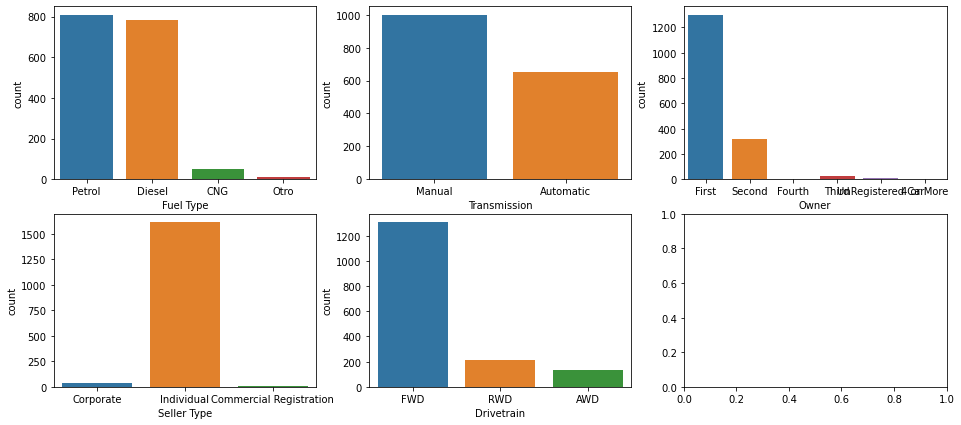

In [9]:
#Visualización de frecuencia de instancias para variables categóricas
plot_multiples_graficas(d,catCols, 3, 2, 'c', None, (16,7))

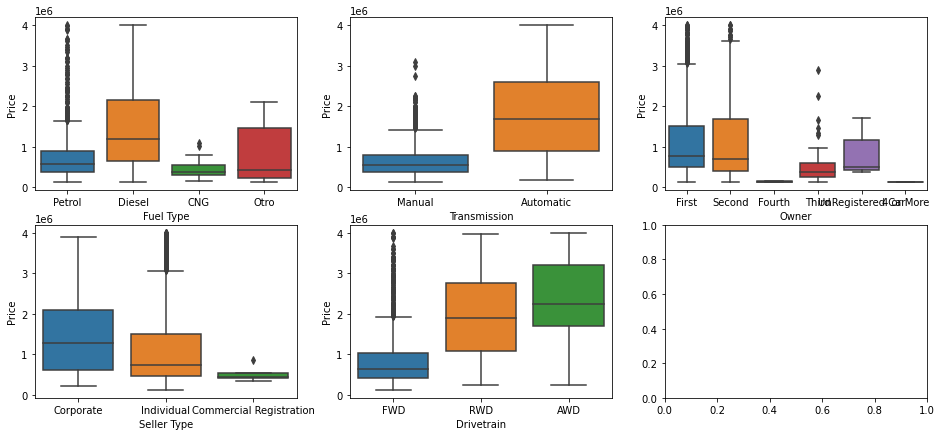

In [10]:
#Visualización por medio de gráficos de caja de bigotes para las variables categóricas con respecto al precio
plot_multiples_graficas (d, catCols, 3, 2, 'b', 'Price', (16,7))

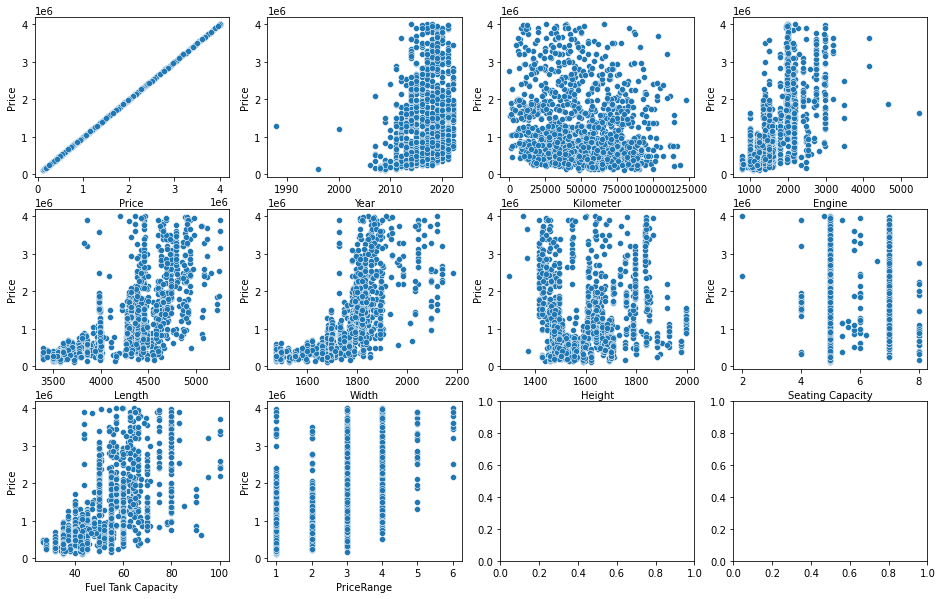

In [11]:
#Visualización de variables numéricas con respecto al precio
plot_multiples_graficas (d, numCols, 4, 3, 's', 'Price', (16,10))


#Tambien puede utilizar la funcion pairplot de seaborn
#sns.pairplot(d[numCols])
#plt.show()

In [12]:
#Eliminar la variable de salida de la lista de variable numéricas
numCols.remove('Price') 

### Variable de salida

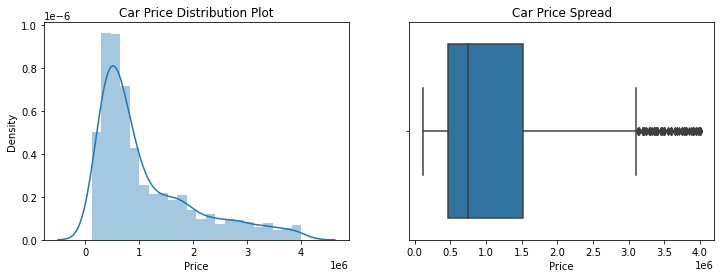

In [13]:
#Histográma y caja de bigotes del precio de los vehículos

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
sns.distplot(d.Price)

plt.subplot(1,2,2)
plt.title('Car Price Spread')
sns.boxplot(x=d.Price)

plt.show()

In [14]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

print(d.Price.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,0.95,0.975,1]))

count      1655
mean    1111698
std      910375
min      120000
25%      459999
50%      750000
75%     1525000
85%     2100000
90%     2600000
95%     3200000
97.5%   3550000
100%    4000000
max     4000000
Name: Price, dtype: float64


## 5. Preparación de datos

### Creación de Variables Dummies

In [15]:
# Aplicación de la función de get_dummies

d =pd.get_dummies(d, drop_first=1)

In [16]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1655 entries, 0 to 1654
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Price                   1655 non-null   float64
 1   Year                    1655 non-null   float64
 2   Kilometer               1655 non-null   float64
 3   Engine                  1655 non-null   float64
 4   Length                  1655 non-null   float64
 5   Width                   1655 non-null   float64
 6   Height                  1655 non-null   float64
 7   Seating Capacity        1655 non-null   float64
 8   Fuel Tank Capacity      1655 non-null   float64
 9   PriceRange              1655 non-null   int64  
 10  Fuel Type_Diesel        1655 non-null   uint8  
 11  Fuel Type_Otro          1655 non-null   uint8  
 12  Fuel Type_Petrol        1655 non-null   uint8  
 13  Transmission_Manual     1655 non-null   uint8  
 14  Owner_First             1655 non-null   

## 6. Creación del modelo

### Dividir el conjunto de datos

In [17]:
#Se establece las variables de entrada 'X' y la variable de salida 'y'

X = d.drop(columns = "Price")
y = d['Price']

In [18]:
# División de los datos en train y test

#En este caso, el 80% de los datos se utilizarán para entrenar el modelo. 

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1), 
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

### Escalar Variables

In [19]:
#Se establecen las variables numéricas a escalar

#Num_vars se le asigna la lista con las variables numerivas para posteriormente escalarlas
num_vars = numCols

print(num_vars)

['Year', 'Kilometer', 'Engine', 'Length', 'Width', 'Height', 'Seating Capacity', 'Fuel Tank Capacity', 'PriceRange']


In [20]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Se crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.fit_transform(X_test[num_vars])

X_train[num_vars].head()

,Year,Kilometer,Engine,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,PriceRange
31,0.7353,0.5425,0.1807,0.5298,0.4694,0.5390,0.6333,0.4110,0.0000
1347,0.8529,0.4444,0.0868,0.3231,0.3108,0.2665,0.5000,0.2466,0.0000
11,0.8824,0.1793,0.0441,0.1529,0.1562,0.2593,0.5000,0.0137,0.0000
275,0.9118,0.5588,0.2969,0.5714,0.5180,1.0000,0.8333,0.4521,0.2000
1425,0.9706,0.2565,0.2969,0.6785,0.7357,0.8954,0.8333,0.4932,0.0000


In [21]:
X_train.head()

,Year,Kilometer,Engine,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,PriceRange,Fuel Type_Diesel,...,Transmission_Manual,Owner_First,Owner_Fourth,Owner_Second,Owner_Third,Owner_UnRegistered Car,Seller Type_Corporate,Seller Type_Individual,Drivetrain_FWD,Drivetrain_RWD
31,0.7353,0.5425,0.1807,0.5298,0.4694,0.5390,0.6333,0.4110,0.0000,0,...,0,1,0,0,0,0,0,1,1,0
1347,0.8529,0.4444,0.0868,0.3231,0.3108,0.2665,0.5000,0.2466,0.0000,0,...,1,1,0,0,0,0,0,1,1,0
11,0.8824,0.1793,0.0441,0.1529,0.1562,0.2593,0.5000,0.0137,0.0000,0,...,1,1,0,0,0,0,0,1,1,0
275,0.9118,0.5588,0.2969,0.5714,0.5180,1.0000,0.8333,0.4521,0.2000,1,...,1,1,0,0,0,0,0,1,0,0
1425,0.9706,0.2565,0.2969,0.6785,0.7357,0.8954,0.8333,0.4932,0.0000,1,...,1,1,0,0,0,0,0,1,0,1


### Creación del modelo

Un Random Forest es un metaestimador que ajusta una serie de árboles de decisión de clasificación en varias submuestras del conjunto de datos y utiliza el promedio para mejorar la precisión predictiva y controlar el sobreajuste. 

**Parametros:**
- **n_estimators:** (default=100) número de árboles del bosque
- **max_depth:** (default=None) La profundidad máxima del árbol. Si es `None`, los nodos se expanden hasta que todas las hojas sean puras o hasta que todas las hojas contengan menos ejemplos del parametro min_samples_split.
- **max_features:** (default=1.0) El número de características a considerar al buscar la mejor división
    - auto, None o 1.0: max_features=n_features.
    - sqrt: max_features=sqrt(n_features).
    - log2: max_features=log2(n_features).

- **bootstrap:**(default=True) Si se utilizan muestras al construir árboles. Si es False, se usa todo el conjunto de datos para construir cada árbol.

- **oob_score:** (default=False) si usa ejemplos out-of-bag para estimar un score de generalización. Solo disponible si bootstrap = True.

In [22]:
# Creación del modelo
# ==============================================================================
modelo = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'mse',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,   #out-of-bag samples
            n_jobs       = -1,
            random_state = 123
         )


# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', max_features='auto', n_estimators=10,
                      n_jobs=-1, random_state=123)

### Evaluación del modelo

#### Error Cuadráico Medio (rmse) y el Coeficiente de Determinación $R^2$

In [23]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelo.predict(X = X_test)

rmse = mean_squared_error(y_true  = y_test, y_pred  = predicciones, squared = False)
print(f"El error (rmse) de test es: {rmse}")

r2 = r2_score(y_test, predicciones)
print(f"El error (r2) de test es: {r2}")

El error (rmse) de test es: 349371.3138971681
El error (r2) de test es: 0.8608209907799765


## 7. Afinando el modelo (tuning)

### Preparacion de datos

Valor óptimo de n_estimators(árboles): 111


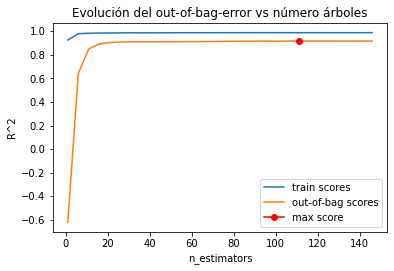

In [24]:
# Validación empleando el Out-of-Bag error : 

# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.

for n_estimators in estimator_range:
    
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'mse',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)
    


# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators(árboles): {estimator_range[np.argmax(oob_scores)]}")

Valor óptimo de n_estimators: 141


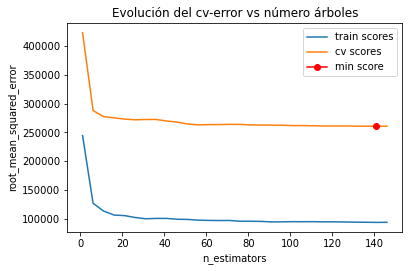

In [25]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
    
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error', #mean squared error: mse
                max_depth    = None,
                max_features = 'auto',
                oob_score    = False,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

**Analísis:** Ambas métricas indican que, a partir de 20 árboles (n_estimators), el error de validación del modelo se estabiliza.

Valor óptimo de max_features: 15


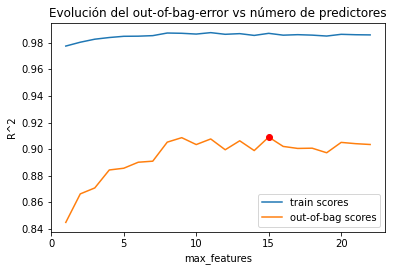

In [26]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1) #X_train.shape[1] = total de características


# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de Out-of-Bag.
for max_features in max_features_range:
    modelo = RandomForestRegressor(
                n_estimators = 20,
                criterion    = 'mse',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")

Valor óptimo de max_features: 13


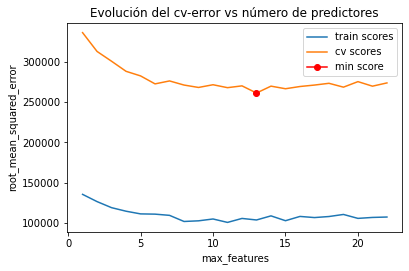

In [27]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de k-cross-validation.
for max_features in max_features_range:
    
    modelo = RandomForestRegressor(
                n_estimators = 20,
                criterion    = 'mse',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, cv_scores, label="cv scores")
ax.plot(max_features_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_features")
ax.set_title("Evolución del cv-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmin(cv_scores)]}")

**Analísis:** Ambas métricas indican que, entre 9 y 15 características se obtiene el mejor R^2 y el menor error

In [28]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [15],
                 'max_features': [9, 11, 13, 15],
                 'max_depth'   : [3, 10, 20]
                }
             )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:
    
    modelo = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_r2'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(5)

Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 15} ✓
Modelo: {'max_depth': 3, 'max_features': 11, 'n_estimators': 15} ✓
Modelo: {'max_depth': 3, 'max_features': 13, 'n_estimators': 15} ✓
Modelo: {'max_depth': 3, 'max_features': 15, 'n_estimators': 15} ✓
Modelo: {'max_depth': 10, 'max_features': 9, 'n_estimators': 15} ✓
Modelo: {'max_depth': 10, 'max_features': 11, 'n_estimators': 15} ✓
Modelo: {'max_depth': 10, 'max_features': 13, 'n_estimators': 15} ✓
Modelo: {'max_depth': 10, 'max_features': 15, 'n_estimators': 15} ✓
Modelo: {'max_depth': 20, 'max_features': 9, 'n_estimators': 15} ✓
Modelo: {'max_depth': 20, 'max_features': 11, 'n_estimators': 15} ✓
Modelo: {'max_depth': 20, 'max_features': 13, 'n_estimators': 15} ✓
Modelo: {'max_depth': 20, 'max_features': 15, 'n_estimators': 15} ✓


,oob_r2,max_depth,max_features,n_estimators
7,0.8966,10,15,15
8,0.8947,20,9,15
6,0.8920,10,13,15
11,0.8911,20,15,15
9,0.8910,20,11,15


In [29]:
# Mejores hiperparámetros por out-of-bag error
# ==============================================================================
print("--------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-r2)")
print("--------------------------------------------")
print(resultados.iloc[0,:]['oob_r2'], "R2")

--------------------------------------------
Mejores hiperparámetros encontrados (oob-r2)
--------------------------------------------
0.8965725906822533 R2


**Analísis:** Con 15 Características, y un maximo nivel de profundidad de 10 se obtiene el mejor R^2 sobre el datatset Out of bag

#### Validación Cruzada

In [30]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [15],
              'max_features': [9, 11, 13, 15],
              'max_depth'   : [ 3, 10, 20]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestRegressor(random_state = 123),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = - 1,
        cv         = 5, 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
9,20,11,15,-263084.7718,20817.4493,-112075.1194,2023.8144
6,10,13,15,-266782.6756,15845.7260,-131884.7809,6505.0618
5,10,11,15,-267102.9625,18926.4895,-134946.2162,5367.8638
10,20,13,15,-268028.1546,18611.1642,-114031.4572,7373.5304


In [31]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'max_depth': 20, 'max_features': 11, 'n_estimators': 15} : -263084.7718046134 neg_root_mean_squared_error


In [32]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo.predict(X = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

r2 = r2_score(y_test, predicciones)
print(f"El error (r2) de test es: {r2}")

El error (rmse) de test es: 303721.0216654375
El error (r2) de test es: 0.894816175342542


### 8.  Importancia de predictores

#### Importancia por pureza de nodos

In [33]:
importancia_predictores = pd.DataFrame(
                            {'predictor': d.drop(columns = "Price").columns,
                             'importancia': modelo.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
2,Engine,0.4127
4,Width,0.2236
0,Year,0.1082
12,Transmission_Manual,0.0659
8,PriceRange,0.0429
1,Kilometer,0.0389
3,Length,0.0365
5,Height,0.0344
7,Fuel Tank Capacity,0.0183
20,Drivetrain_FWD,0.0049


#### Referencias


- Random Forest
    - https://www.cienciadedatos.net/documentos/py08_random_forest_python.html
    - https://fhernanb.github.io/libro_mod_pred/rand-forests.html
    - https://scikit-learn.org/stable/modules/model_evaluation.html
    